In [6]:
import pandas as pd
import numpy as np
import h5py
from scipy.stats import binned_statistic
import warnings

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use(["classic"])

mpl.rc( 'lines', linewidth=3 )
mpl.rc( 'font', family='monospace', weight='normal', size=20 )

c_frame = (0,0,0,.8)
for tick in 'xtick', 'ytick':
    mpl.rc( tick+'.major', width=1.5, size=8)
    mpl.rc( tick+'.minor', width=1, size=4, visible=True )
    mpl.rc( tick, color=c_frame, labelsize=18, direction='in' )
mpl.rc( 'xtick', top=True )
mpl.rc( 'ytick', right=True )
mpl.rc( 'axes', linewidth=1.5, edgecolor=c_frame, labelweight='normal' )
mpl.rc( 'grid', color=c_frame)
mpl.rc( 'patch', edgecolor=c_frame)

In [2]:
def prop_bin(x_prop, y_prop, x_edges, sig_num = 1):
    '''
    Bin datas into bins of x_prop, and calculate the median value of y_prop in each bin with error.
    '''
    
    #   Exclude the data with nan and inf
    finite_ind = np.isfinite(x_prop) & np.isfinite(y_prop)
    x_prop = x_prop[finite_ind]
    y_prop = y_prop[finite_ind]

    #   Calculate the median value of y_prop in each bin
    bin_mid = (x_edges[:-1] + x_edges[1:]) / 2
    prop_cnt = binned_statistic(x_prop, y_prop,statistic='count', bins=x_edges).statistic
    prop_mid = np.where(prop_cnt >= sig_num, binned_statistic(x_prop, y_prop,statistic='median', bins=x_edges).statistic, np.nan)
    prop_std = np.where(prop_cnt >= sig_num, binned_statistic(x_prop, y_prop,statistic='std', bins=x_edges).statistic, np.nan)
    prop_err = 1.253 * prop_std / np.sqrt(prop_cnt)

    return bin_mid, prop_mid, prop_err

def moving_average(x_prop, y_prop, y_err, ave_step):
    y_prop_ave = pd.DataFrame(y_prop).rolling(ave_step, center=True, min_periods=1).mean().values.flatten()
    ind_finite = np.isfinite(y_prop)
    return x_prop[ind_finite], y_prop_ave[ind_finite], y_err[ind_finite]

def ave_bin(x_prop, y_prop, x_edges, x_min, ave_step, sig_num = 1):
    x_mid, y_mid, y_err = prop_bin(x_prop, y_prop, x_edges, sig_num = sig_num)
    x_mid_ave, y_mid_ave, y_err_ave = moving_average(x_mid, y_mid, y_err, ave_step)
    return x_mid_ave[x_mid_ave >= x_min], y_mid_ave[x_mid_ave >= x_min], y_err_ave[x_mid_ave >= x_min]

# Data

Stellar Metallicity

In [24]:
tng_z_star_df = pd.read_csv('/Users/abry/Library/CloudStorage/OneDrive-北京大学/Lessons/Lesson_1_2/galaxy/Quenching/tng_z_star.csv')

In [28]:
tng_z_star_sf_df = tng_z_star_df.loc[
    (tng_z_star_df.log_sfr.values > (0.7 * tng_z_star_df.log_m_star.values - 7.52)), :].reset_index(drop=True)
tng_z_star_gv_df = tng_z_star_df.loc[
    ((tng_z_star_df.log_sfr.values > (0.7 * tng_z_star_df.log_m_star.values - 8.02))
    & (tng_z_star_df.log_sfr.values <= (0.7 * tng_z_star_df.log_m_star.values - 7.52))), :].reset_index(drop=True)
tng_z_star_q_df = tng_z_star_df.loc[
    (tng_z_star_df.log_sfr.values <= (0.7 * tng_z_star_df.log_m_star.values - 8.02)), :].reset_index(drop=True)

In [37]:
m_star_edges = np.arange(9, 12.02,0.02)
sig_num = 30
m_th_sf, m_th_gv, m_th_q = 0,0,0
mz_tng_sf, z_tng_sf, z_err_tng_sf = ave_bin(
    tng_z_star_sf_df.log_m_star.values, tng_z_star_sf_df.log_z_star.values, 
    m_star_edges, m_th_sf, 10, sig_num)
mz_tng_gv, z_tng_gv, z_err_tng_gv = ave_bin(
    tng_z_star_gv_df.log_m_star.values, tng_z_star_gv_df.log_z_star.values,
    m_star_edges, m_th_gv, 10, sig_num)
mz_tng_q, z_tng_q, z_err_tng_q = ave_bin(
    tng_z_star_q_df.log_m_star.values, tng_z_star_q_df.log_z_star.values,
    m_star_edges, m_th_q, 10, sig_num)


Stellar mass weighted age

In [7]:
tng_color_age_df = pd.read_csv('/Users/abry/Projects/SFH_from_TNG/Data/TNG/tng_color_age.csv')

In [17]:
tng_age_star_df = tng_color_age_df.loc[:,['log_m_star', 'log_sfr', 'mw_age', 'lw_age_30kpc']].rename(columns={'mw_age':'mw_age_gyr', 'lw_age_30kpc':'lw_age_gyr'}).copy()

In [34]:
tng_age_star_sf_df = tng_age_star_df.loc[
    (tng_age_star_df.log_sfr.values > (0.7 * tng_age_star_df.log_m_star.values - 7.52)), :].reset_index(drop=True)
tng_age_star_gv_df = tng_age_star_df.loc[
    ((tng_age_star_df.log_sfr.values > (0.7 * tng_age_star_df.log_m_star.values - 8.02))
    & (tng_age_star_df.log_sfr.values <= (0.7 * tng_age_star_df.log_m_star.values - 7.52))), :].reset_index(drop=True)
tng_age_star_q_df = tng_age_star_df.loc[
    (tng_age_star_df.log_sfr.values <= (0.7 * tng_age_star_df.log_m_star.values - 8.02)), :].reset_index(drop=True)

In [38]:
m_star_edges = np.arange(9, 12.02,0.02)
sig_num = 30
m_th_sf, m_th_gv, m_th_q = 0,0,0
ma_tng_sf, a_tng_sf, a_err_tng_sf = ave_bin(
    tng_age_star_sf_df.log_m_star.values, tng_age_star_sf_df.mw_age_gyr.values,
    m_star_edges, m_th_sf, 10, sig_num)
ma_tng_gv, a_tng_gv, a_err_tng_gv = ave_bin(
    tng_age_star_gv_df.log_m_star.values, tng_age_star_gv_df.mw_age_gyr.values,
    m_star_edges, m_th_gv, 10, sig_num)
ma_tng_q, a_tng_q, a_err_tng_q = ave_bin(
    tng_age_star_q_df.log_m_star.values, tng_age_star_q_df.mw_age_gyr.values,
    m_star_edges, m_th_q, 10, sig_num)

# Plot

In [36]:
mpl.rcParams['lines.linewidth'] = 1.2
mpl.rcParams['lines.linestyle'] = '-'
mpl.rcParams['lines.marker'] = 'None'
mpl.rcParams['errorbar.capsize'] = 0.6
mpl.rcParams['grid.alpha'] = 0.6
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['legend.fontsize'] = 18

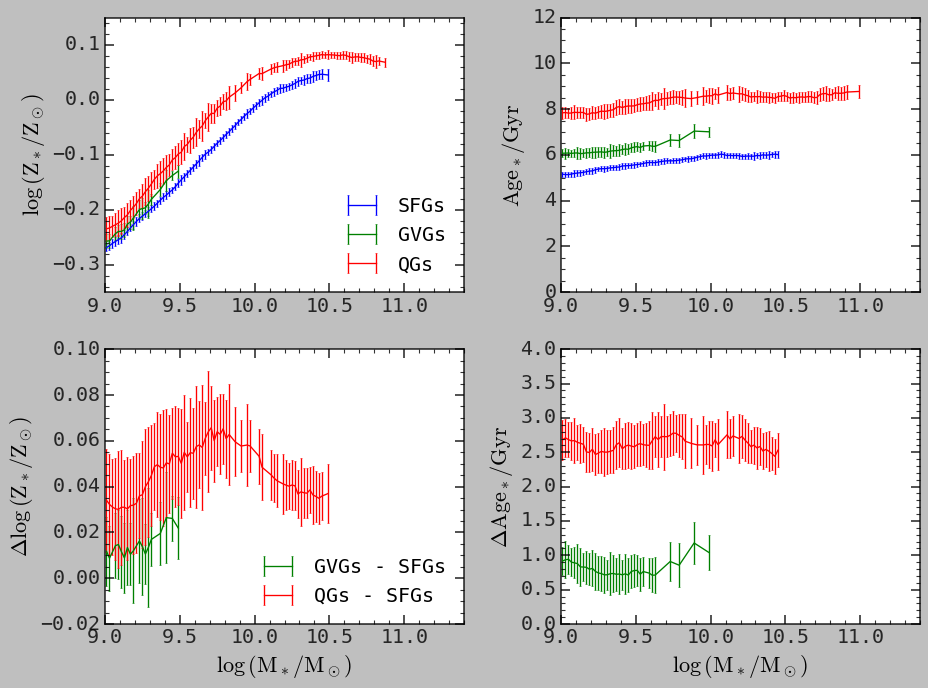

In [61]:
fig, axes = plt.subplots(2, 2, figsize=(12, 9))
ax1, ax2, ax3, ax4 = axes.flatten()

# ax1: TNG Stellar Metallicity
ax1.errorbar(mz_tng_sf, z_tng_sf, yerr=z_err_tng_sf, c='b', label='SFGs', ls='-', )
ax1.errorbar(mz_tng_gv, z_tng_gv, yerr=z_err_tng_gv, c='g', label='GVGs', ls='-', )
ax1.errorbar(mz_tng_q, z_tng_q, yerr=z_err_tng_q, c='r', label='QGs', ls='-', )

# ax2: TNG Stellar Age
ax2.errorbar(ma_tng_sf, a_tng_sf, yerr=a_err_tng_sf, c='b', label='SFGs', ls='-', )
ax2.errorbar(ma_tng_gv, a_tng_gv, yerr=a_err_tng_gv, c='g', label='GVGs', ls='-', )
ax2.errorbar(ma_tng_q, a_tng_q, yerr=a_err_tng_q, c='r', label='QGs', ls='-', )

# ax3: Delta TNG Stellar Metallicity
mz_tng_sf_gv, indz_tng_gv_sf, indz_tng_sf_gv = np.intersect1d(mz_tng_sf, mz_tng_gv, return_indices = True, assume_unique = True)
mz_tng_sf_q, indz_tng_q_sf, indz_tng_sf_q = np.intersect1d(mz_tng_sf, mz_tng_q, return_indices = True, assume_unique = True)
ax3.errorbar(mz_tng_sf_gv, z_tng_gv[indz_tng_sf_gv] - z_tng_sf[indz_tng_gv_sf],
                yerr=np.sqrt(z_err_tng_gv[indz_tng_sf_gv]**2 + z_err_tng_sf[indz_tng_gv_sf]**2),
                 c='g', label='GVGs - SFGs', ls='-',)
ax3.errorbar(mz_tng_sf_q, z_tng_q[indz_tng_sf_q] - z_tng_sf[indz_tng_q_sf],
                yerr=np.sqrt(z_err_tng_q[indz_tng_sf_q]**2 + z_err_tng_sf[indz_tng_q_sf]**2),
                c='r', label='QGs - SFGs', ls='-',)

# ax4: Delta TNG Stellar Age
ma_tng_sf_gv, inda_tng_gv_sf, inda_tng_sf_gv = np.intersect1d(ma_tng_sf, ma_tng_gv, return_indices = True, assume_unique = True)
ma_tng_sf_q, inda_tng_q_sf, inda_tng_sf_q = np.intersect1d(ma_tng_sf, ma_tng_q, return_indices = True, assume_unique = True)
ax4.errorbar(ma_tng_sf_gv, a_tng_gv[inda_tng_sf_gv] - a_tng_sf[inda_tng_gv_sf],
                yerr=np.sqrt(a_err_tng_gv[inda_tng_sf_gv]**2 + a_err_tng_sf[inda_tng_gv_sf]**2),
                c='g', label='GVGs - SFGs', ls='-',)
ax4.errorbar(ma_tng_sf_q, a_tng_q[inda_tng_sf_q] - a_tng_sf[inda_tng_q_sf],
                yerr=np.sqrt(a_err_tng_q[inda_tng_sf_q]**2 + a_err_tng_sf[inda_tng_q_sf]**2),
                c='r', label='QGs - SFGs', ls='-',)

ax1.legend(loc='lower right')
ax3.legend(loc='lower right')

ax1.set_ylim(-0.35, 0.15)
ax2.set_ylim(0.,12.)
ax3.set_ylim(-0.02,0.1)
ax4.set_ylim(0,4.)


for ax in axes.flatten():
    ax.set_xlim(9, 11.4)
    

ax1.set_ylabel(r'$\log \rm (Z_*/Z_\odot)$')
ax2.set_ylabel(r'$\rm Age_*/Gyr$')
ax3.set_ylabel(r'$\Delta \log \rm (Z_*/Z_\odot)$')
ax4.set_ylabel(r'$\Delta \rm Age_*/Gyr$')

ax3.set_xlabel(r'$\log \rm (M_* / M_\odot)$')
ax4.set_xlabel(r'$\log \rm (M_* / M_\odot)$')
fig.tight_layout()
plt.savefig('/Users/abry/Library/CloudStorage/OneDrive-北京大学/Lessons/Lesson_1_2/galaxy/Quenching/tng_results.pdf', dpi=300, format='pdf', bbox_inches='tight')